In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, AutoEncoderDataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
import seaborn as sns
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers
#from sklearn import decomposition
#from sklearn.metrics import r2_score

Using TensorFlow backend.


In [2]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)
keras.__version__

'2.2.5'

In [3]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [4]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

In [5]:
eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}

# Comparison with baseline across shots

In [6]:
# Note: compile flag must be set to False if you wish to experiment with differing forecast horizons

# model = keras.models.load_model('/scratch/gpfs/aiqtidar/run_results_11_06/run_results_11_06_run/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_06Nov20-07-57_Scenario-3.h5', compile=True)
# with open('/scratch/gpfs/aiqtidar/run_results_11_06/run_results_11_06_run/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_06Nov20-07-57_Scenario-3_params.pkl', 'rb') as f:
#     scenario = pickle.load(f, encoding='latin1')

model = keras.models.load_model('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0.h5', compile=True)
with open('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

#scenario['lookahead'] = 4

W0303 00:56:07.965706 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0303 00:56:07.991915 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0303 00:56:08.233319 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0303 00:56:08.841129 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use

In [7]:
datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = None, #scenario['invert_q'],
                                                              val_idx = 0,
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
valdata = denormalize(valdata, normalization_dict)
valdata = renormalize(valdata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(valdata,
                                               1,  
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])

Signals: curr, dens, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, temp, tinj
Number of useable shots:  5531
Number of shots used:  5531
Total number of timesteps:  586968
Shots with Complete NaN: 
125691 samples total
Removing weird I-coils
Removed 24703 samples
100988 samples remaining
Removing NaN
Removed 0 samples
100988 samples remaining
Removing dudtrip
Removed 7074 samples
93914 samples remaining
93914 samples remaining after pruning


Normalizing: 100%|##########| 15/15 [00:00<00:00, 153.91it/s]

Total number of samples:  93914
Number of training samples:  84213
Number of validation samples:  9701


In [8]:
predictions_arr = model.predict_generator(generator, verbose=1)

9701/9701 [==============================] - 10s 1ms/step


In [9]:
# This block is for manual prediction generation
# Use when you want to experiment with different forecast horizons
# SKIP if you are using model.predict_generator()

def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    '''
    state_decoder = Model(model.get_layer('state_decoder_time_dist').layer.layers[0].input,
                             model.get_layer('state_decoder_time_dist').layer.layers[-2].get_output_at(1),
                             name='state_decoder')    
    control_decoder = Model(model.get_layer('ctrl_decoder_time_dist').layer.layers[0].input,
                                model.get_layer('ctrl_decoder_time_dist').layer.layers[-2].get_output_at(1),
                                name='control_decoder')
    '''
    return state_encoder, state_decoder, control_encoder


def get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,**kwargs):
    import numpy as np
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    # encode control    
    T = scenario['lookback'] + scenario['lookahead'] 
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    x = [x0]
    for i in range(scenario['lookahead']):
        x.append(A.dot(x[i])+B.dot(u[i]))
       
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.dsplit((np.array([x_decoded[j] for j in range(len(x_decoded))])),5)[i])
        residuals[sig] = state_inputs[sig] - state_predictions[sig]

    return state_inputs, state_predictions, residuals


A, B = get_AB(model)
state_encoder, state_decoder, control_encoder = get_submodels(model)
model_err = {sig:[] for sig in scenario['profile_names']}
for i in range(len(generator)):
    print("{}/{}".format(i+1,len(generator)),end='\r')
    __,__,resids = get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,generator[i])
    for sig in scenario['profile_names']:
        model_err[sig].append(np.abs(resids[sig][-1]))

In [61]:
# Compute model and baseline error

full_profiles = {sig:[] for sig in scenario['profile_names']}
baseline_err = {sig:[] for sig in scenario['profile_names']}


#For each batch
for i in range(len(generator)):
    print("{}/{}".format(i+1,len(generator)),end='\r')
    sample = generator[i]
    #Append each sample
    for sig in scenario['profile_names']:
        full_profiles[sig].append(sample[0]['input_'+sig])
        
for sig in scenario['profile_names']:
    ##for each batch
    for i in range(len(full_profiles[sig])):
        print("{}/{}".format(i+1,len(full_profiles[sig])),end='\r')
        #For each sample
        for j in range(len(full_profiles[sig][i])):
            baseline_err[sig].append(np.abs(full_profiles[sig][i][j][-1]-full_profiles[sig][i][j][0]))
            
# Use this block ONLY when you are using keras' inbuilt predict_generator().

model_err = {sig:[] for sig in scenario['profile_names']}
for i in range(len(predictions_arr[0])):
    for j, sig in enumerate(scenario['profile_names']):
        model_err[sig].append(np.abs(predictions_arr[0][i][-1][j*33:((j+1)*33)]))


In [62]:
bas_tot = {sig:[] for sig in scenario['profile_names']}
mod_tot = {sig:[] for sig in scenario['profile_names']}

for sig in scenario['profile_names']:
    
    bas_tot[sig] = np.median(np.array(baseline_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0)
    mod_tot[sig] = np.median(np.array(model_err[sig])*scenario['normalization_dict'][sig]['iqr'],axis=0)
    
    # Print out 2-norm of median error for each profile
    print('model ' + sig + ' error: ' + str(np.linalg.norm(mod_tot[sig], ord=2)))
    print('baseline ' + sig + ' error: ' + str(np.linalg.norm(bas_tot[sig], ord=2)))
    
    

model temp error: 0.34378445
baseline temp error: 0.69381523
model dens error: 0.0
baseline dens error: 1.7664917
model ffprime_EFIT02 error: 0.0
baseline ffprime_EFIT02 error: 1.5726266
model press_EFIT02 error: 0.0
baseline press_EFIT02 error: 15284.364
model q_EFIT02 error: 0.0
baseline q_EFIT02 error: 0.41237557


In [13]:
"""get median and 25/75 percentile errors, denormalized, for model and baseline"""

hi_per = 75
low_per = 25

hiper_model_err = {sig:np.percentile(np.array(model_err[sig])*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['profile_names']}
hiper_baseline_err = {sig:np.percentile(np.array(baseline_err[sig])*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['profile_names']}

lowper_model_err = {sig:np.percentile(np.array(model_err[sig])*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['profile_names']}
lowper_baseline_err = {sig:np.percentile(np.array(baseline_err[sig])*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['profile_names']}


ValueError: operands could not be broadcast together with shapes (33,) (4,) 

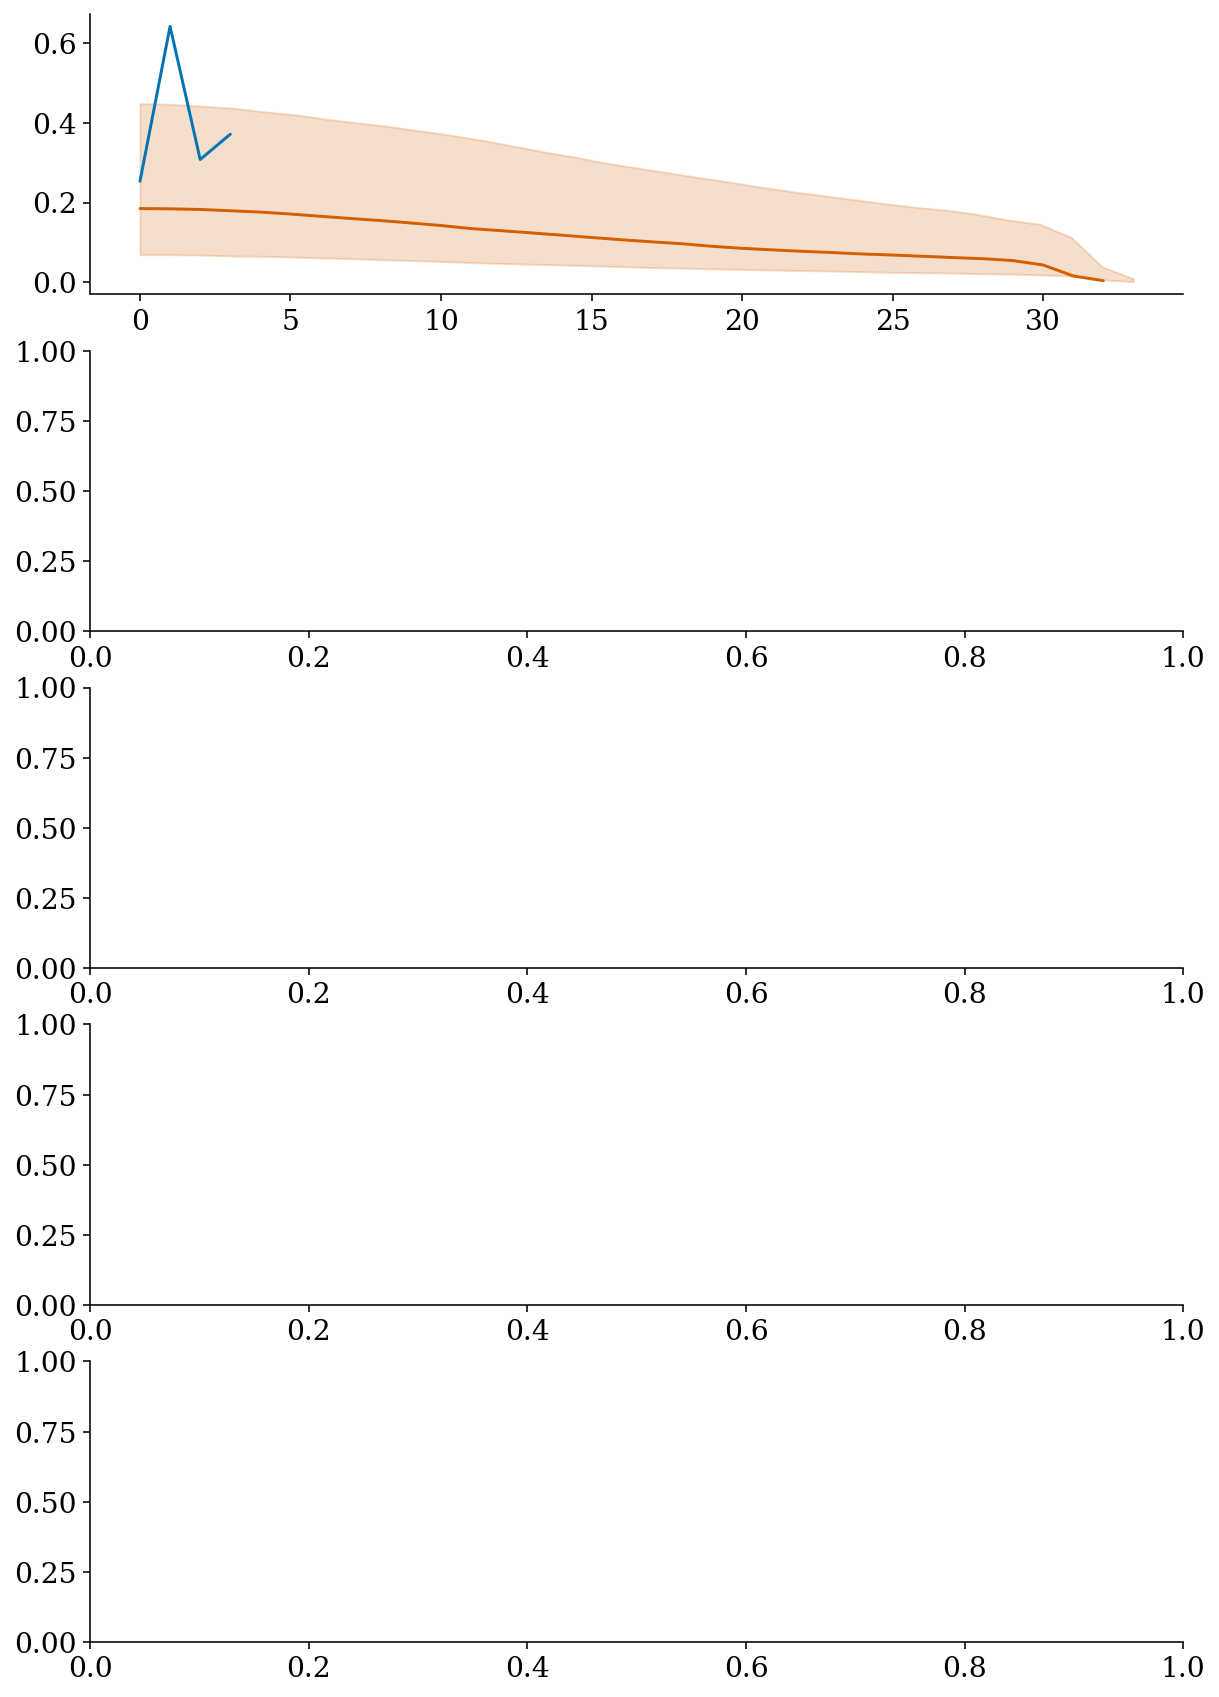

In [14]:
# Plot model vs baseline

fig, ax = plt.subplots(len(scenario['profile_names']),1,figsize=(10,15))
psi = np.linspace(0,33,33)
for i,sig in enumerate(scenario['profile_names']):
    
    ax[i].plot(bas_tot[sig], label='baseline',color=colorblind_colors[1],lw=1.5)
    ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)  
    ax[i].plot(mod_tot[sig], label='model', color=colorblind_colors[0], lw=1.5)
    ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(sig,size=16)
plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=16);
fig.suptitle("200ms",y=0.9)
fig.show()

5878


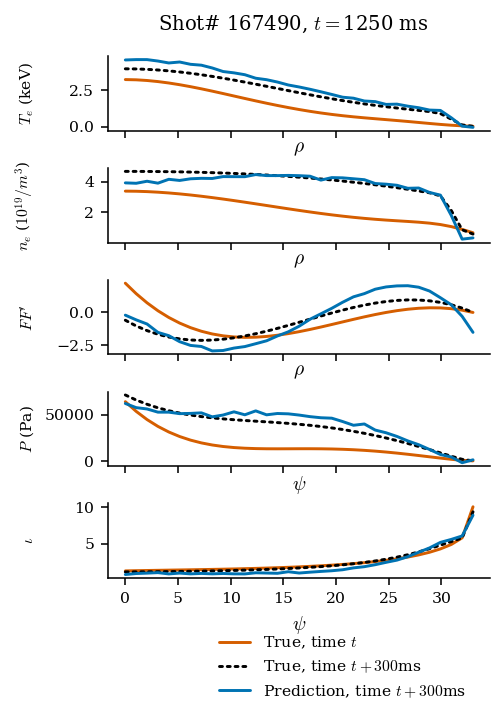

In [63]:
# Model Prediction vs True

good_indices = [5085,8351,1749,10746,7299,479,9980,5878,1297,12951]

#index = np.random.randint(len(data_generator))
index = good_indices[7]
print(index)
inputs, targets,_ = generator[index]
profiles = scenario['profile_names']#['dens','temp','rotation','q_EFIT02','press_EFIT02']

shotnum = generator.cur_shotnum[0,0]
#shotnum = 176153
shottime = generator.cur_times[0,-scenario['lookahead']-1]

predictions=model.predict_on_batch(inputs)

fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
for j, profile in enumerate(profiles):
    if ('input_{}'.format(profile)) in inputs:
        ax = axes[j]
        inp = inputs['input_{}'.format(profile)][0][0].squeeze()
        true = inputs['input_{}'.format(profile)][0][-1].squeeze()
        pred = inputs['input_{}'.format(profile)][0][-1].squeeze() + predictions[1][0][-1][j*33:(j+1)*33].squeeze()

        inp = helpers.normalization.denormalize_arr(inp,scenario['normalization_dict'][profile])
        true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])
        pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])

        ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
        ax.plot(psi,true,lw=1.5,label='True, time $t+300$ms',c='k',ls=':')
        ax.plot(psi,pred,lw=1.5,label='Prediction, time $t+300$ms',c=colorblind_colors[0])

        ax.set_ylabel(labels[profile],size=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        #ax.set_xticks([0,.5,1])
        #ax.set_xlim(0,1)
        if j in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if j in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
fig.align_ylabels(axes)
plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
fig.legend(handles=axes[0].lines,     
           labels=[line._label for line in axes[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.12),
           frameon=False,
           mode=None,
           ncol=1,
          fontsize=8)
#fig.savefig('images/timeslice_{}.png'.format(index),bbox_inches='tight',pad_inches=0.1)
#fig.savefig('images/timeslice_{}.pdf'.format(index),bbox_inches='tight',pad_inches=0.1)

In [46]:
generator

# PCA Plots

In [14]:
#Helper functions
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

In [15]:
pca_generator = AutoEncoderDataGenerator(valdata,
                                               1,
                                               scenario['profile_names'],
                                               [],
                                               [],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               False)

In [16]:
# Generate PCA eigenvectors

num_components=10
pca_fit = {}
baseline = {}
for j,profile in enumerate(scenario['profile_names']):
    #If PCA plot of deltas are desired use:
    #full = np.array([pca_generator[i][0]['input_' + profile][0][-1] - pca_generator[i][0]['input_' + profile][0][0] for i in range(len(pca_generator))]).squeeze()
    full = np.array([pca_generator[i][0]['input_' + profile][0][-1] for i in range(len(pca_generator))]).squeeze()
    baseline[profile] = full
    print(full.shape)
    print(profile, ' made arrays')
    pca_fit[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')

(25564, 33)
temp  made arrays
temp  done full
(25564, 33)
dens  made arrays
dens  done full
(25564, 33)
rotation  made arrays
rotation  done full
(25564, 33)
press_EFIT02  made arrays
press_EFIT02  done full
(25564, 33)
q_EFIT02  made arrays
q_EFIT02  done full


In [17]:
# Find PCA coefficients
profiles = scenario['profile_names']

num_samples = baseline[profiles[0]].shape[0]
scalarize_functions = [scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names = [fun.__name__[10:] for fun in scalarize_functions]

all_true_prof = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_predicted_prof = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}

for j,profile in enumerate(profiles):
    for k in range(num_samples):
        target = baseline[profile][k][np.newaxis,:]
        pred = (predictions_arr[0][k][-1][j*33:((j+1)*33)]+baseline[profile][k])[np.newaxis,:]
        for i,scalarize in enumerate(scalarize_functions):
            all_true_prof[profile][scalarize_function_names[i]][k] = scalarize(target, fitter=pca_fit[profile])
            all_predicted_prof[profile][scalarize_function_names[i]][k] = scalarize(pred, fitter=pca_fit[profile])  

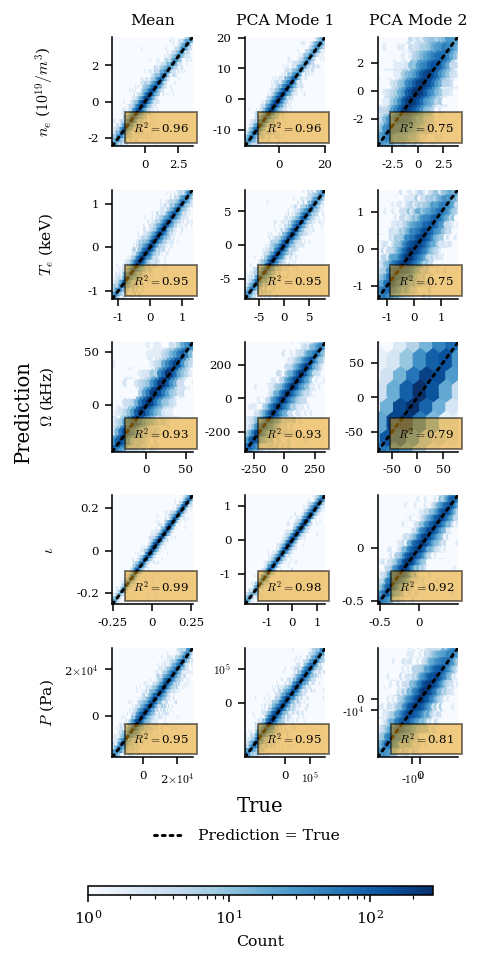

In [18]:
"""Scatter plot of PCA Coeffs"""


def my_formatter(x, pos):
    if abs(x - int(x))< np.finfo(np.float32).eps:
        return str(int(x))
    else:
        return str(np.around(x,3))
#         if x<0:
#             return str(x)[:6]
#         else:
#             return str(x)[:5]

formatter = matplotlib.ticker.FuncFormatter(my_formatter)

profiles = ['dens','temp','rotation','q_EFIT02','press_EFIT02']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(3.5,7))

for i,profile in enumerate(profiles):
    for j,name in enumerate(scalarize_function_names):

        pred=copy.deepcopy(all_predicted_prof[profile][name])
        true=copy.deepcopy(all_true_prof[profile][name])

        ax = axes[i,j]
#         if name in ['Mean','Std. Dev.']:
        pred *= scenario['normalization_dict'][profile]['iqr']
        true *= scenario['normalization_dict'][profile]['iqr']
        
        bounds = find_bounds(true,pred,95)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

        r2_model = r2_score(true,pred)
        r2_baseline = r2_score(true, np.zeros(true.shape))

        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_model), fontsize=6, horizontalalignment='right',verticalalignment='bottom', 
                transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[-1], alpha=0.5))
#         ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_baseline), fontsize=8, horizontalalignment='right',verticalalignment='bottom', 
#                 transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[1], alpha=0.5)) 

        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k', linestyle=':',lw=1.5,label='Prediction = True')
#         ax.axhline(0,color=colorblind_colors[1],lw=1.5,label='Baseline')
        if i==0:
            ax.set_title(scatter_titles[name], size=8)
#         if i==len(profiles)-1:
#             ax.set_xlabel('True',size=10)
        if j in [0]:
            ax.set_ylabel(labels[profile], size=8)
#         if j in [1,2,3]:
#             if ylabels[i] == '$q$':
#                 ax.set_ylabel(labels[i] + ' \n Prediction', size=10)
#             else:
#                 ax.set_ylabel(labels[i] + ' (unitless) \n Prediction', size=10)
        ax.tick_params(axis='both', which='major', labelsize=6)
#         ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)

# axes[3,1].set_xticks([-.25,0,.25])
# axes[3,1].set_xticklabels(['-0.25','0','0.25'])
# axes[3,2].set_xticks([-.25,0,.25])
# axes[3,2].set_xticklabels(['-0.25','0','0.25'])

axes[4,0].set_yticks([0,20000])
axes[4,0].set_yticklabels(['0',r'2$\times 10^4$'])
axes[4,0].set_xticks([0,20000])
axes[4,0].set_xticklabels(['0',r'2$\times 10^4$'])

axes[4,1].set_yticks([0,100000])
axes[4,1].set_yticklabels(['0',r'$10^5$'])
axes[4,1].set_xticks([0,100000])
axes[4,1].set_xticklabels(['0',r'$10^5$'])

axes[4,2].set_yticks([0,-10000])
axes[4,2].set_yticklabels(['0',r'-$10^4$'])
axes[4,2].set_xticks([0,-10000])
axes[4,2].set_xticklabels(['0',r'-$10^4$'])

plt.subplots_adjust(hspace=0.4,wspace=0.65,bottom=0.15, left=0.2)

fig.text(0.5, 0.1, 'True', va='center', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Prediction', va='center', ha='center', rotation='vertical', fontsize=10)

fig.align_ylabels(axes[:,0])



cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)

fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.15),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=8);
#fig.savefig('images/all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
#fig.savefig('images/all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)

In [ ]:
"""plot full pca modes"""
psi = np.linspace(0,1,scenario['profile_length'])
labels = ['$n_e$','$T_e$','$\Omega$','$\iota$','$P$']
profiles = ['dens','temp','rotation','q_EFIT02','press_EFIT02']

ncols = 2
nrows = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(3.5,5))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))


for i,profile in enumerate(profiles):
    pca=pca_fit[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca.components_[j],lw=1)
        ax.text(0.3,0.25,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=8)
        if j==0:
            ax.set_ylabel(labels[i], size=8)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        if i in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if i in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
# fig.savefig('images/pca_modes.pdf')
# fig.savefig('images/pca_modes.png')

In [ ]:
from matplotlib.ticker import MaxNLocator
"""plot explained variance"""

ylabels = ['$n_e$','$T_e$','$\Omega$','$\iota$','$P$']

fig, axes = plt.subplots(1,len(profiles),sharey=False,figsize=(10,2))
for j,profile in enumerate(profiles):
    pca=pca_fit[profile]
    ax = axes[j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_),)
    ax.set_ylabel(ylabels[j],size=10)
    ax.set_xlabel('N modes', size=8)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid()
    ax.tick_params(axis='both', which='both', labelsize=6)
    
fig.suptitle('Explained Variance (full profiles)', size=10)
plt.subplots_adjust(wspace=0.7)
# fig.savefig('explained_variance.png')

# All old stuff below. Use autoencoder_plot.py instead

# "A" (Koopman Approximation) and "B" (recurrent actuator weights) Visualization

In [ ]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    #state_decoder = Model(model.get_layer('state_decoder_time_dist').layer.layers[0].input,
    #                      model.get_layer('state_decoder_time_dist').layer.layers[-2].get_output_at(1),
    #                     name='state_decoder')    
    #control_decoder = Model(model.get_layer('ctrl_decoder_time_dist').layer.layers[0].input,
    #                        model.get_layer('ctrl_decoder_time_dist').layer.layers[-2].get_output_at(1),
    #                        name='control_decoder')
 
    return state_encoder, state_decoder, control_encoder #, control_decoder

def plot_autoencoder_AB(model,scenario, filename=None, **kwargs):
    
    A,B = get_AB(model)
    f, axes = plt.subplots(1, 2, figsize=(28, 14),
                           gridspec_kw={'width_ratios': [scenario['state_latent_dim'], 
                                                         scenario['control_latent_dim']]})
    sns.heatmap(A, 
                cmap=kwargs.get('cmap','Spectral'),
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[0]).set_title('A')
    sns.heatmap(B,
                cmap=kwargs.get('cmap','Spectral'), 
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[1]).set_title('B')

    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

# Eigenvalue plots of A matrix

In [ ]:
def plot_autoencoder_spectrum(model,scenario, filename=None, **kwargs):

    font={'family': 'DejaVu Serif',
          'size': 18}
    plt.rc('font', **font)
    matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)
    
    dt = scenario['dt']
    A,B = get_AB(model)
    eigvals, eigvecs = np.linalg.eig(A)
    logeigvals = np.log(eigvals)
    for i, elem in enumerate(logeigvals):
        if abs(np.imag(elem)-np.pi)<np.finfo(np.float32).resolution:
            logeigvals[i] = np.real(elem) + 0j
    logeigvals = logeigvals/dt

    f, axes = plt.subplots(1, 2, figsize=(28, 14))
    axes[0].scatter(np.real(eigvals),np.imag(eigvals))
    t = np.linspace(0,2*np.pi,1000)
    axes[0].plot(np.cos(t),np.sin(t))

    axes[0].set_title('Eigenvalues of A')
    axes[0].grid(color='gray')
    axes[0].set_xlabel('Re($\lambda$)')
    axes[0].set_ylabel('Im($\lambda$)')


    axes[1].scatter(np.real(logeigvals),np.imag(logeigvals))
    axes[1].set_title('Eigenvalues of A')
    axes[1].grid(color='gray')
    axes[1].set_xlabel('Growth Rate (1/s)')
    axes[1].set_ylabel('$\omega$ (rad/s)')
    axes[1].set_xlim((1.1*np.min(np.real(logeigvals)),np.maximum(1.1*np.max(np.real(logeigvals)),0)))
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

# Autoencoder Training Plots

In [ ]:
def plot_autoencoder_training(model,scenario,filename=None,**kwargs):

    f, axes = plt.subplots(2, 2, figsize=(28, 28))
    axes[0,0].semilogy(scenario['history']['loss'],label='train')
    axes[0,0].semilogy(scenario['history']['val_loss'],label='val')
    axes[0,0].set_title('Loss')
    axes[0,0].legend()
    
    axes[0,1].semilogy(scenario['history']['x_residual_mean_squared_error'],label='train')
    axes[0,1].semilogy(scenario['history']['val_x_residual_mean_squared_error'],label='val')
    axes[0,1].set_title('X residual MSE')
    axes[0,1].legend()
    '''
    axes[1,0].semilogy(scenario['history']['u_residual_mean_squared_error'],label='train')
    axes[1,0].semilogy(scenario['history']['val_u_residual_mean_squared_error'],label='val')
    axes[1,0].set_title('U residual MSE')
    axes[1,0].legend()
    '''
    axes[1,1].semilogy(scenario['history']['linear_system_residual_mean_squared_error'],label='train')
    axes[1,1].semilogy(scenario['history']['val_linear_system_residual_mean_squared_error'],label='val')
    axes[1,1].set_title('Linear Model MSE')
    axes[1,1].legend()
    
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f
        

# Observability and Controlability Analysis

In [ ]:
def stabAnalysis(model, scenario, filename = None):
    A,B = get_AB(model)
    dt = .05
    # Ac = logm(Ad)/dt
    Ac = scipy.linalg.logm(A)/dt
    # Bc = inv(Ad-I)*Ac*Bd
    Bc = np.matmul(np.linalg.inv(A-np.eye(scenario['state_latent_dim'])),np.matmul(Ac,B))
    C = np.eye(scenario['state_latent_dim'])
    D = np.zeros((scenario['state_latent_dim'],scenario['control_latent_dim']))

    Wcc = scipy.linalg.solve_continuous_lyapunov(Ac,-Bc.dot(Bc.T))
    Wdc = scipy.linalg.solve_discrete_lyapunov(A,B.dot(B.T))

    Wco = scipy.linalg.solve_continuous_lyapunov(Ac.T,-C.dot(C.T)).T
    Wdo = scipy.linalg.solve_discrete_lyapunov(A.T,C.dot(C.T)).T

    fig = plt.figure(figsize=(28,14))
    plt.subplot(1,2,1,title='Wcc, Wdc')
    plt.semilogy(np.linalg.svd(Wcc,compute_uv=False), label ='wcc')
    plt.semilogy(np.linalg.svd(Wdc,compute_uv=False), label = 'wdc')
    plt.legend(loc='best')

    plt.subplot(1,2,2, title = 'Wco, Wdo')
    plt.semilogy(np.linalg.svd(Wco,compute_uv=False),label = 'wco')
    plt.semilogy(np.linalg.svd(Wdo,compute_uv=False), label = 'wdo')

    plt.legend(loc='best')
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    
    return fig

# Plot State and Control Residuals for Specified Shot

In [ ]:
def get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,shot,**kwargs):
    import numpy as np
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs['input_'+sig][:,0,:].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs['input_'+sig][:,0].reshape((1,1,1))
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs['input_'+sig]
    # encode control    
    T = scenario['lookback'] + scenario['lookahead'] + 1
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    x = [x0]
    for i in range(scenario['lookahead']):
        x.append(A.dot(x[i])+B.dot(u[i]))
        '''
        print(x[i])
        print('Control')
        print(B.dot(u[i]))
        '''
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.dsplit((np.array([x_decoded[j] for j in range(len(x_decoded))])),5)[i])
        residuals[sig] = state_inputs[sig] - state_predictions[sig]

    return state_inputs, state_predictions, residuals

def plot_autoencoder_residuals(model,scenario,generator,shots,times, filename = None,**kwargs):
    A, B = get_AB(model)
    state_encoder, state_decoder, control_encoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    psi = np.linspace(0,1,scenario['profile_length'])
    nsteps = scenario['lookahead']
    
    fig = plt.figure(figsize=(40, 60))
    outer_grid = fig.add_gridspec(len(times),1)
    
    for k, (shot,time) in enumerate(zip(actual['shots'],actual['times'])):
        inp = {sig:arr[np.newaxis,k] for sig, arr in inputs.items()}
        state_inputs, state_predictions, residuals = get_autoencoder_predictions(
            state_encoder,state_decoder,control_encoder,A,B,scenario,inp,shot)
        
        outerax = fig.add_subplot(outer_grid[k])
        outerax.set_title(label='Shot ' + str(int(shot)) + '   Time ' + str(int(time)),pad = 30)
        outerax.axis('off')
        
        inner_grid = outer_grid[k].subgridspec(1, nsteps)
        for j in range(nsteps):
            ax = fig.add_subplot(inner_grid[j])
            for i, sig in enumerate(scenario['profile_names']):
                ax.plot(psi,residuals[sig][j].reshape((scenario['profile_length'],)),label=sig)
                ax.hlines(0,0,1)
                ax.legend()
                ax.tick_params(reset=True)
                ax.set_title(label = 'State Residuals t+' + str(int(j*scenario['dt']*1000)))
            fig.add_subplot(ax)
      
    if filename:
        fig.savefig(filename, bbox='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    return fig 
    
def plot_autoencoder_predictions_timestep(model,scenario,generator,shots,times, filename = None,**kwargs):
    A,B = get_AB(model)
    state_encoder, state_decoder, control_encoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    
    fig = plt.figure(figsize=(40,90))
    outer_grid = fig.add_gridspec(len(times),1)
    
    for i, (shot,time) in enumerate(zip(actual['shots'],actual['times'])):
        inp = {sig:arr[np.newaxis,i] for sig, arr in inputs.items()}
        state_inputs, state_predictions, residuals = get_autoencoder_predictions(
            state_encoder,state_decoder,control_encoder,A,B,scenario,inp,shot)
        baseline = {k:v[0].reshape((scenario['profile_length'],)) for k,v in state_inputs.items() if k in scenario['profile_names']}
        true = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_inputs.items() if k in scenario['profile_names']}
        pred = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_predictions.items() if k in scenario['profile_names']}
        
        outerax = fig.add_subplot(outer_grid[i])
        outerax.set_title(label='Shot ' + str(int(shot)) + '   Time ' + str(int(time)) + '   Prediction Window ' 
                     + str(int(scenario['lookahead']*scenario['dt']*1000)),pad = 70)
        outerax.axis('off')
        
        ncols = len(scenario['profile_names'])
        nrows = 2
        psi = np.linspace(0,1,scenario['profile_length'])
        inner_grid = outer_grid[i].subgridspec(nrows, ncols)
        
        for j, sig in enumerate(scenario['profile_names']):
            ax = fig.add_subplot(inner_grid[j]) 
            ax.plot(psi,pred[sig]-baseline[sig],psi,true[sig]-baseline[sig])
            ax.set_title(label = sig + ' (deltas)')
            ax.hlines(0,0,1)
            ax.legend(['predicted delta','true delta'])
            
            ax1 = fig.add_subplot(inner_grid[j+ncols]) 
            ax1.plot(psi,pred[sig],psi,true[sig],psi, baseline[sig])
            ax1.set_title(label = sig + ' (full)')
            ax1.legend(['predicted','true','baseline'])
            
            fig.add_subplot(ax)
            fig.add_subplot(ax1)
            
    if filename:
        fig.savefig(filename, bbox='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    
    return fig        

def plot_autoencoder_control_encoding(model,scenario,generator,shots,times,filename=None,**kwargs):
    state_encoder, state_decoder, control_encoder = get_submodels(model)
    inputs, targets, actual = generator.get_data_by_shot_time(shots,times)
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs['input_'+sig]
    figsize = (20,10)
    nrows = int(np.ceil(len(shots)/3))
    ncols = min(len(shots),3)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize,squeeze=False,sharey=True)
    fig.suptitle('Control Residuals',y=.95)
    
    for j, (shot,time) in enumerate(zip(shots,times)):
        inp = {sig:arr[j] for sig, arr in control_inputs.items() }
        residuals = []
        T = scenario['lookback'] + scenario['lookahead'] +1
        for i in range(T):
            temp_input = {k:v[i].reshape((1,1,1)) for k,v in inp.items()}
            encoded_control = control_encoder.predict(temp_input)
            residuals.append(np.squeeze(control_decoder.predict(encoded_control)))
        residuals = {sig:np.squeeze(inp['input_'+sig]-np.array(residuals)[:,i]) for i, sig in enumerate(scenario['actuator_names'])}
        
        t = np.arange(time,time+(T)*scenario['dt']*1000,scenario['dt']*1000)
        for i, sig in enumerate(scenario['actuator_names']):
            ax[np.unravel_index(j,(nrows,ncols))].plot(t,residuals[sig], label=sig)
            ax[np.unravel_index(j,(nrows,ncols))].hlines(0,min(t),max(t))
            ax[np.unravel_index(j,(nrows,ncols))].tick_params(reset=True)
            ax[np.unravel_index(j,(nrows,ncols))].legend()
            ax[np.unravel_index(j,(nrows,ncols))].title.set_text('Shot ' + str(int(shot)) + '   Time ' + str(int(time)))
      
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)     

    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html    
    return fig


# state_inputs, state_predictions, residuals = get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,175702,1400)
# f = plot_autoencoder_residuals(residuals,scenario,175702,1400)
# f = plot_autoencoder_predictions_timestep(state_inputs, state_predictions, scenario,175702,1400)

# Load files 

In [ ]:
run_path = '/scratch/gpfs/aaronwu/run_results_07_21_2'
scenarios = []
models = []
for file in os.listdir(run_path):
    if file.endswith(".h5"):
        model_path = run_path+'/'+file
        #model = keras.models.load_model(model_path, compile=False)
        #models.append(model)
        #print('loaded model: ' + model_path.split('/')[-1])
        params_path = model_path[:-3]+'_params.pkl'
        with open(params_path, 'rb') as f:
            scenario = pickle.load(f, encoding='latin1')
            scenario['dt'] = 0.05
            scenarios.append(scenario)
        print('loaded dict: ' + params_path.split('/')[-1])

In [ ]:
#Include in for loop if lookback/lookahead vary

datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
data = {163303: rawdata[163303]}
times = [2000, 2480, 3080, 4040, 4820, 5840]
shots = [163303]*len(times)
traindata, valdata, normalization_dict = process_data(data,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookback'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1,
                                                      0,
                                                      scenario['nshots'],
                                                      1,
                                                      scenario['flattop_only'],
                                                      invert_q = scenario['invert_q'],
                                                      randomize=False)
traindata = denormalize(traindata, normalization_dict)
traindata = renormalize(traindata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(traindata,
                                               scenario['batch_size'],
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])

# Write Scenario 

In [ ]:
def write_results(model, scenario, worksheet):
    
    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    '''
    base_sheet_path = "https://docs.google.com/spreadsheets/d/1h2jm3PWuck-7t_WcHi3Zm0OT35fRfLr4RrrUjHrm1dA/edit#gid=0"
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
    client = gspread.authorize(creds)
    sheet = client.open_by_url(base_sheet_path).get_worksheet(worksheet)
    
    write_scenario_to_sheets(scenario,sheet)
    rowid = sheet.find(scenario['runname']).row
    scenario['sheet_path'] = base_sheet_path + "&range={}:{}".format(rowid,rowid)
    '''
    results_dir = os.path.expanduser('~/results/'+scenario['runname'])  
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    os.chdir(results_dir)
    f = open('index.html','w+')
    f.write('<html><head></head><body>')
    html = scenario_to_html(scenario)
    f.write(html + '<p>\n')
    _, html = plot_autoencoder_training(model,scenario, filename='training.png')
    f.write(html + '<p>\n')
    
    _, html = plot_autoencoder_AB(model,scenario, filename='AB.png')
    f.write(html + '<p>\n')
    _, html = plot_autoencoder_spectrum(model,scenario, filename='spectrum.png')
    f.write(html + '<p>\n')
    
    _, html = plot_autoencoder_residuals(model,scenario,generator,shots,times, filename = 'state_residuals.png')
    f.write(html + '<p>\n')
    
    _, html = plot_autoencoder_predictions_timestep(model,scenario,generator,shots,times, filename = 'predictions.png')
    f.write(html + '<p>\n')
    '''
    _, html =  plot_autoencoder_control_encoding(model,scenario,generator,shots,times,filename='control_residuals.png')
    f.write(html + '<p>\n')
    '''
    f.write('</body></html>')
    f.close()
    
    
def write_scenario_to_sheets(scenario,sheet):
    sheet_keys = sheet.row_values(1)
    row = [None]*len(sheet_keys)
    for i,key in enumerate(sheet_keys):
        if key in scenario.keys():
            row[i] = str(scenario[key])
        elif key in scenario.get('history',{}):
            row[i] = str(scenario['history'][key][-1])
    sheet.append_row(row)

def scenario_to_html(scenario):
    foo = {k:v for k,v in scenario.items() if k not in ['history','normalization_dict','history_params']}
    def printitems(dictObj, indent=0):
        p=[]
        p.append('<ul>\n')
        for k,v in dictObj.items():
            if isinstance(v, dict):
                p.append('<li><b>'+ str(k)+ '</b>: ')
                p.append(printitems(v))
                p.append('</li>\n')
            elif k in ['image_path','sheet_path']:
                p.append("<a href=\"" + str(v) + "\">" + str(k) + "</a>\n")          
            else:
                p.append('<li><b>'+ str(k)+ '</b>: '+ str(v)+ '</li>\n')
        p.append('</ul>\n')
        return ''.join(p)
    return printitems(foo)

In [ ]:
%%capture
#Worksheet 0 for vanilla, 1 for LRAN, 2 for LRAN2
for model, scenario in zip(models, scenarios):
    write_results(model,scenario,1)

In [ ]:
base_sheet_path = "https://docs.google.com/spreadsheets/d/1h2jm3PWuck-7t_WcHi3Zm0OT35fRfLr4RrrUjHrm1dA/edit#gid=0"
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
client = gspread.authorize(creds)
sheet = client.open_by_url(base_sheet_path).get_worksheet(1)


for scenario in scenarios:
    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    write_scenario_to_sheets(scenario, sheet)

In [ ]:
%%capture
# Architecture Visualization
for model,scenario in zip(models, scenarios):
    dot = model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB')
    dot.write_png('/home/aaronwu/results/'+scenario['runname']+'/architecture.png')
    #display(dot.create_png())
    #print('\n'+'\n')